In [3]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 2.3 MB/s eta 0:00:06
   - -------------------------------------- 0.5/13.3 MB 7.1 MB/s eta 0:00:02
   -- ------------------------------------- 0.9/13.3 MB 6.9 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/13.3 MB 7.0 MB/s eta 0:00:02
   ---- ----------------------------------- 1.5/13.3 MB 8.0 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/13.3 MB 7.4 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/13.3 MB 7.3 MB/s eta 0:00:02
   ------- -------------------------------- 2.4/13.3 MB 7.3 MB/s eta 0:00:02
   ------- -------------------------------- 2.7/13.3 MB 7.1 MB/s eta 0:00:02
   --------- ------------------------------ 3.0/13.3 MB 7.4 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/13.3 MB 7.5 MB/s eta 0:00:02
   ---------- ----------------------------- 3.6/13.3 MB 7.1 MB/s eta 0:00:02
   ---

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [5]:
data = pd.read_excel("Pizza_Sale.xlsx")

In [6]:
data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [8]:
data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [9]:
data.dropna(inplace=True)

In [10]:
data.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [11]:
data.duplicated().sum()

0

In [12]:
#changing order date into datetime format

data["order_date"]=pd.to_datetime(data["order_date"],errors="coerce")

In [13]:
#feature engineering

data[["order_hour","order_day","order_month","order_week"]] = pd.DataFrame({
    "order_hour": data["order_date"].dt.hour,
    "order_day": data["order_date"].dt.day,
    "order_month": data["order_date"].dt.month,
    "order_week": data["order_date"].dt.isocalendar().week
})


In [14]:
data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,order_hour,order_day,order_month,order_week
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,0,1,1,1
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,1,1
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,0,1,1,1
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,0,1,1,1
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,0,1,1,1


In [15]:
data["order_day"].value_counts()

order_day
15    1844
27    1763
7     1736
2     1695
9     1695
12    1680
5     1658
4     1658
6     1654
20    1650
17    1649
14    1643
13    1643
11    1614
16    1609
8     1599
23    1595
3     1595
18    1589
1     1584
21    1560
24    1546
26    1504
22    1484
19    1463
28    1450
30    1439
29    1361
10    1353
25    1245
31     996
Name: count, dtype: int64

In [18]:
# Ingredient Data

df= pd.read_excel("Pizza_ingredients.xlsx")

In [19]:
df.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [21]:
df.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [22]:
df.dropna(inplace=True)

In [23]:
df.duplicated().sum()

0

In [24]:
df.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [25]:
pizza= pd.merge(data,df,on="pizza_name_id",how="inner")

In [26]:
pizza.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,order_hour,order_day,order_month,order_week,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,0,1,1,1,The Hawaiian Pizza,Pineapple,30.0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,0,1,1,1,The Hawaiian Pizza,Mozzarella Cheese,20.0
2,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,1,1,The Classic Deluxe Pizza,Pepperoni,40.0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,1,1,The Classic Deluxe Pizza,Mushrooms,40.0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,0,1,1,1,The Classic Deluxe Pizza,Red Onions,40.0


In [27]:
#finding total sale per day

total_sales=data.groupby("order_date")["quantity"].sum().reset_index()

In [28]:
total_sales

,order_date,quantity
0,2015-01-01,156
1,2015-01-02,191
2,2015-01-03,99
3,2015-01-04,135
4,2015-01-05,154
...,...,...
353,2015-12-27,89
354,2015-12-28,102
355,2015-12-29,80
356,2015-12-30,82


In [29]:
# DATA VISUALIZATION

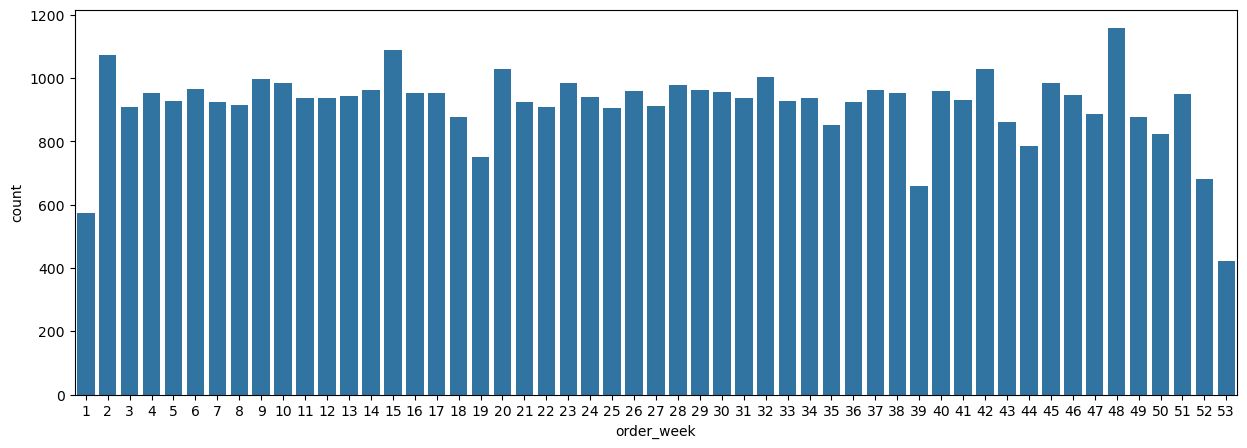

In [30]:
# countplot for order for a week
plt.figure(figsize=(15,5))
sns.countplot(data=data,x=data["order_week"])
plt.show()

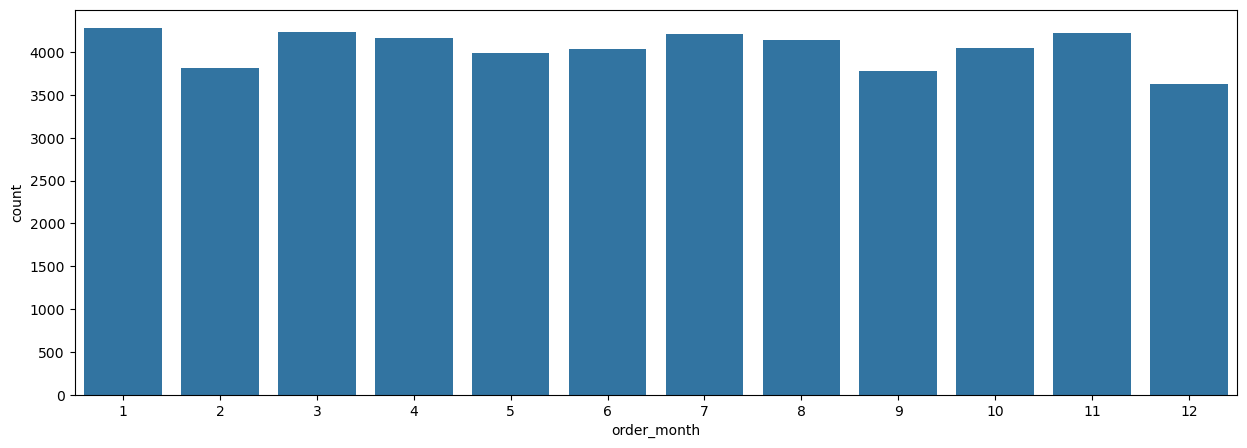

In [31]:
# countplot for monthly order
plt.figure(figsize=(15,5))
sns.countplot(data=data,x=data["order_month"])
plt.show()

In [32]:
data["pizza_name"].value_counts()

pizza_name
The Classic Deluxe Pizza                      2416
The Barbecue Chicken Pizza                    2368
The Hawaiian Pizza                            2365
The Pepperoni Pizza                           2364
The Thai Chicken Pizza                        2313
The California Chicken Pizza                  2299
The Sicilian Pizza                            1884
The Spicy Italian Pizza                       1884
The Southwest Chicken Pizza                   1883
The Italian Supreme Pizza                     1848
The Four Cheese Pizza                         1847
The Big Meat Pizza                            1810
The Vegetables + Vegetables Pizza             1510
The Mexicana Pizza                            1453
The Napolitana Pizza                          1447
The Spinach and Feta Pizza                    1430
The Prosciutto and Arugula Pizza              1426
The Pepper Salami Pizza                       1420
The Italian Capocollo Pizza                   1412
The Greek Pizza     

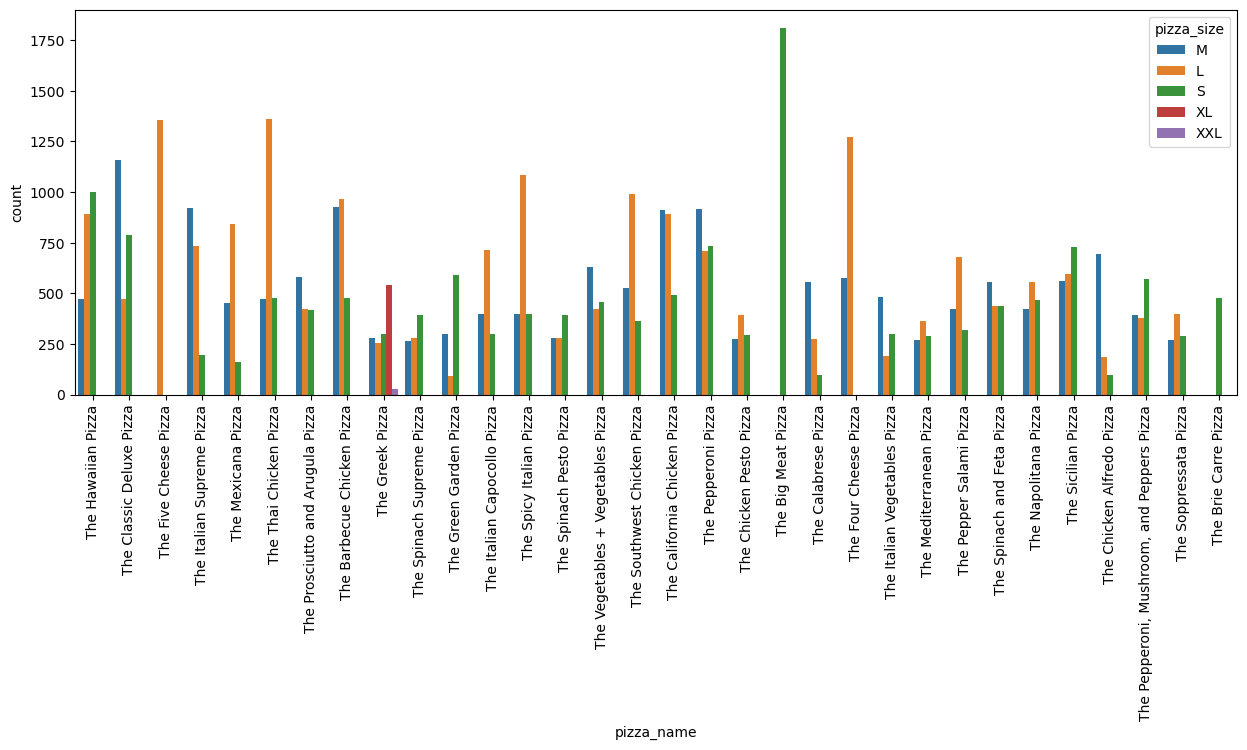

In [33]:
# countplot for monthly order
plt.figure(figsize=(15,5))
sns.countplot(data=data,x="pizza_name",hue="pizza_size")
plt.xticks(rotation=90)
plt.show()

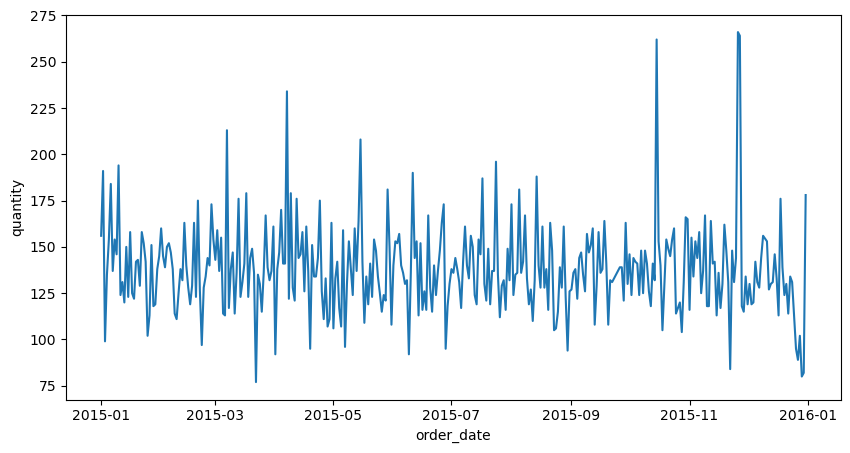

In [34]:
plt.figure(figsize=(10,5))
sns.lineplot(data=total_sales,x="order_date",y="quantity")
plt.show()

# ML MODEL

In [35]:
#installing prophet

!pip install prophet


In [36]:
#setting cuf-off data for split

total_sales.tail()

,order_date,quantity
353,2015-12-27,89
354,2015-12-28,102
355,2015-12-29,80
356,2015-12-30,82
357,2015-12-31,178


In [37]:
#Taking last two months as test data

cut_off= "2015-10-30"

In [38]:
# Renaming the columns to match the prophet

total_sales.rename(columns={"order_date":"ds","quantity":"y"},inplace=True)  #ds means data series whcih represent the date columm
                                                                                # y is target variable which is quantity

In [39]:
# splitting the data into train and test

train_data = total_sales[total_sales["ds"]<=cut_off]
test_data = total_sales[total_sales["ds"]>cut_off]

In [40]:
#initializing the model

model = Prophet()

In [41]:
#fit the model on train data
model.fit(train_data)

18:25:31 - cmdstanpy - INFO - Chain [1] start processing
18:25:32 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
#make future prediction for test data

future = model.make_future_dataframe(periods=len(test_data))  #here periods is size of test data which is 59 days
forecast = model.predict(future)

In [43]:
#predicted values for test period
predicted_test = forecast[forecast["ds"]>cut_off][["ds","yhat"]]

In [44]:
# actual value and predicted value
actual_value= test_data["y"].values
predicted_value =predicted_test["yhat"].values

In [45]:
test_data["y"].count()

60

In [46]:
train_data["y"].count()

298

In [47]:
mape= mean_absolute_percentage_error(actual_value,predicted_value)
print(f"mean_absolute_percentage_error:{mape}")

mean_absolute_percentage_error:0.15625010664253064


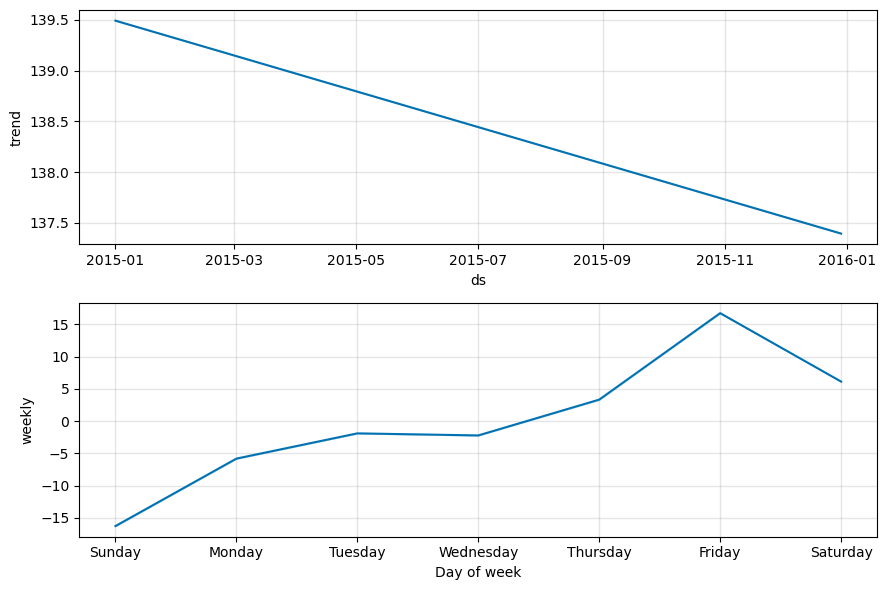

In [48]:
fig = model.plot_components(forecast)
plt.show()

In [49]:
# predicting future values

In [50]:
total_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      358 non-null    datetime64[ns]
 1   y       358 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.7 KB


In [51]:
model_1= Prophet(weekly_seasonality=True,changepoint_prior_scale=0.5,n_changepoints=50,changepoint_range=0.2)

In [52]:
model_1.add_seasonality(name='weekly', period=7, fourier_order=5)

In [53]:
model_1.fit(total_sales)

18:25:39 - cmdstanpy - INFO - Chain [1] start processing
18:25:40 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
#create a future dataframe for the next 7 days

future_1 = model_1.make_future_dataframe(periods=7)

In [55]:
#make prediction for the next 7 days

forecast_1 = model_1.predict(future_1)

In [56]:
predicted_sales=forecast_1[['ds', 'yhat']].tail(7)

In [57]:
predicted_sales

,ds,yhat
358,2016-01-01,155.018358
359,2016-01-02,140.732166
360,2016-01-03,119.398782
361,2016-01-04,131.772103
362,2016-01-05,132.526492
363,2016-01-06,133.739875
364,2016-01-07,142.915533


In [58]:
predicted=forecast_1[["ds","yhat"]]

In [59]:
predicted_value=forecast_1[["yhat"]].tail(7).values

In [60]:
actual_sales=total_sales.iloc[0:7]

In [61]:
actual_sales

,ds,y
0,2015-01-01,156
1,2015-01-02,191
2,2015-01-03,99
3,2015-01-04,135
4,2015-01-05,154
5,2015-01-06,184
6,2015-01-07,137


In [62]:
actual_value=actual_sales[["y"]].values 

In [63]:
mape= np.mean((np.abs(actual_value-predicted_value)/actual_value))*100

In [64]:
print(f"Mean absolute percentage error:{mape:.2f}%")

Mean absolute percentage error:13.65%


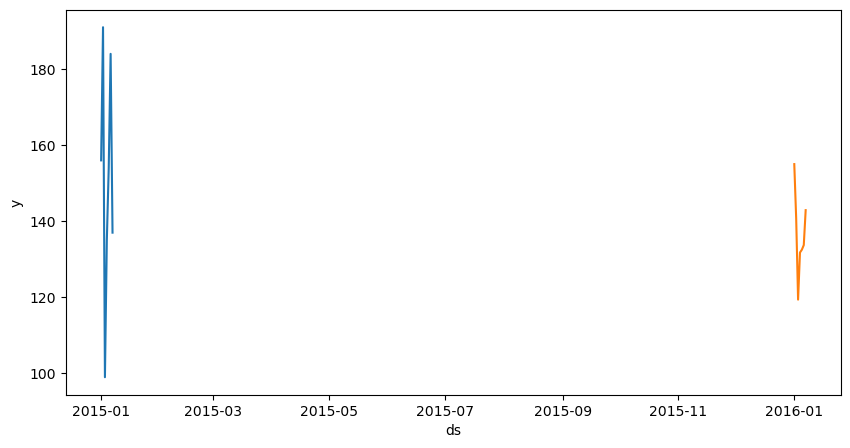

In [65]:
plt.figure(figsize=(10,5))
sns.lineplot(data=actual_sales,x="ds",y="y")
sns.lineplot(data=predicted_sales,x="ds",y="yhat")
plt.show()

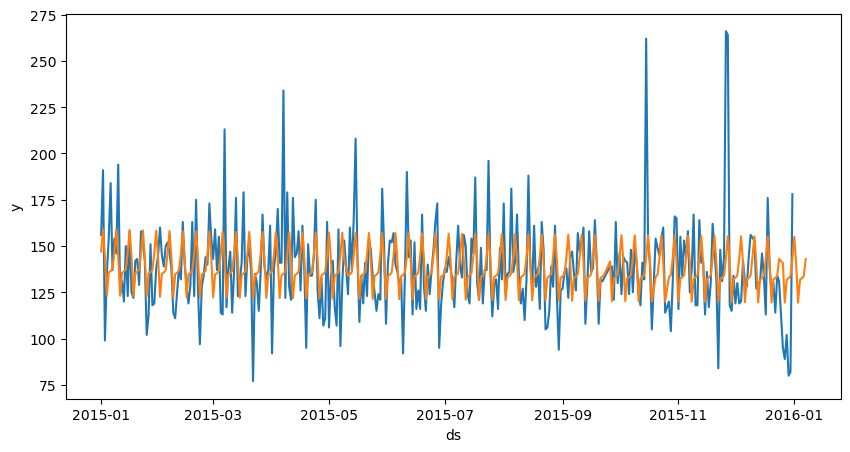

In [66]:
plt.figure(figsize=(10,5))
sns.lineplot(data=total_sales,x="ds",y="y")
sns.lineplot(data=predicted,x="ds",y="yhat")
plt.show()

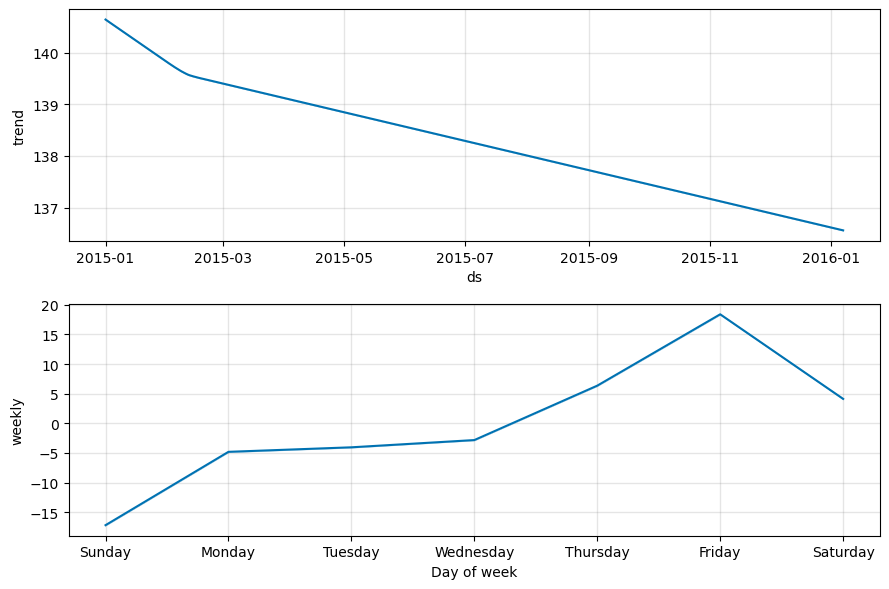

In [67]:
forecast_1 = model_1.predict(future_1)
fig = model_1.plot_components(forecast_1)


In [68]:
# Ingredient Calculation

In [69]:
pizza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264380 entries, 0 to 264379
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pizza_id             264380 non-null  int64         
 1   order_id             264380 non-null  int64         
 2   pizza_name_id        264380 non-null  object        
 3   quantity             264380 non-null  int64         
 4   order_date           264380 non-null  datetime64[ns]
 5   order_time           264380 non-null  object        
 6   unit_price           264380 non-null  float64       
 7   total_price          264380 non-null  float64       
 8   pizza_size           264380 non-null  object        
 9   pizza_category       264380 non-null  object        
 10  pizza_ingredients_x  264380 non-null  object        
 11  pizza_name_x         264380 non-null  object        
 12  order_hour           264380 non-null  int32         
 13  order_day     

In [70]:
predicted_sales

,ds,yhat
358,2016-01-01,155.018358
359,2016-01-02,140.732166
360,2016-01-03,119.398782
361,2016-01-04,131.772103
362,2016-01-05,132.526492
363,2016-01-06,133.739875
364,2016-01-07,142.915533


In [71]:
# Initialize an empty list to hold ingredient requirements
ingredient_requirements = []

# Loop through the predicted sales DataFrame
for index, row in predicted_sales.iterrows():
    one_week = row["ds"]  #get the current date
    total_predicted_sales = int(row["yhat"])  #predicted sales for the day

    #loop through the ingredients dataframe
    for _, ingredient_row in df.iterrows():
        #calculate the total quantity needed for the week for each ingredient
        ingredient_qty = ingredient_row["Items_Qty_In_Grams"] * total_predicted_sales
        
        #append the ingredient requirements to the list
        ingredient_requirements.append({
            "Date": one_week,
            "Ingredient": ingredient_row["pizza_ingredients"],
            "Total Quantity Needed (grams)": ingredient_qty,
            "Items_Qty_In_Grams": ingredient_row["Items_Qty_In_Grams"],
            
        })

# Convert the list to a DataFrame
ingredient_requirements_df = pd.DataFrame(ingredient_requirements)

# Reset index for better readability
ingredient_requirements_df.reset_index(drop=True, inplace=True)





In [72]:
print(predicted_sales)


            ds        yhat
358 2016-01-01  155.018358
359 2016-01-02  140.732166
360 2016-01-03  119.398782
361 2016-01-04  131.772103
362 2016-01-05  132.526492
363 2016-01-06  133.739875
364 2016-01-07  142.915533


In [73]:
ingredient_requirements_df

,Date,Ingredient,Total Quantity Needed (grams),Items_Qty_In_Grams
0,2016-01-01,Barbecued Chicken,6200.0,40.0
1,2016-01-01,Red Peppers,2325.0,15.0
2,2016-01-01,Green Peppers,3100.0,20.0
3,2016-01-01,Tomatoes,4650.0,30.0
4,2016-01-01,Red Onions,9300.0,60.0
...,...,...,...,...
3593,2016-01-07,Green Peppers,2840.0,20.0
3594,2016-01-07,Red Onions,2840.0,20.0
3595,2016-01-07,Zucchini,1420.0,10.0
3596,2016-01-07,Spinach,2130.0,15.0


In [74]:
ingredient_requirements_df.duplicated().sum()

2366

In [75]:
ingredient_requirements_df.drop_duplicates(subset=["Date","Ingredient","Total Quantity Needed (grams)","Items_Qty_In_Grams"],inplace=True)

In [76]:
ingredient_requirements_df.duplicated().sum()

0

In [77]:
ingredient_requirements_df

,Date,Ingredient,Total Quantity Needed (grams),Items_Qty_In_Grams
0,2016-01-01,Barbecued Chicken,6200.0,40.0
1,2016-01-01,Red Peppers,2325.0,15.0
2,2016-01-01,Green Peppers,3100.0,20.0
3,2016-01-01,Tomatoes,4650.0,30.0
4,2016-01-01,Red Onions,9300.0,60.0
...,...,...,...,...
3569,2016-01-07,Feta Cheese,11360.0,80.0
3570,2016-01-07,Tomatoes,7100.0,50.0
3571,2016-01-07,Garlic,3550.0,25.0
3572,2016-01-07,Beef Chuck Roast,28400.0,200.0


In [78]:
ingredient_requirements_df.reset_index(drop=True, inplace=True)

In [79]:
ingredient_requirements_df

,Date,Ingredient,Total Quantity Needed (grams),Items_Qty_In_Grams
0,2016-01-01,Barbecued Chicken,6200.0,40.0
1,2016-01-01,Red Peppers,2325.0,15.0
2,2016-01-01,Green Peppers,3100.0,20.0
3,2016-01-01,Tomatoes,4650.0,30.0
4,2016-01-01,Red Onions,9300.0,60.0
...,...,...,...,...
1227,2016-01-07,Feta Cheese,11360.0,80.0
1228,2016-01-07,Tomatoes,7100.0,50.0
1229,2016-01-07,Garlic,3550.0,25.0
1230,2016-01-07,Beef Chuck Roast,28400.0,200.0


# PURCHASE ORDER

In [84]:
purchase_order = ingredient_requirements_df.copy()

In [85]:
purchase_order["Items_Qty_In_Grams"] = "Grams"

In [86]:
#renaming the columns
purchase_order.rename(columns={"Items_Qty_In_Grams":"Units"}, inplace=True)
purchase_order.rename(columns={"Total Quantity Needed (grams)":"Total Quantity Required"}, inplace=True)
purchase_order.rename(columns={"Total Quantity Required":"Ingredient Usage"}, inplace=True)

In [87]:
purchase_order =purchase_order[["Ingredient","Ingredient Usage","Units","Date"]]

In [88]:
purchase_order.head()

,Ingredient,Ingredient Usage,Units,Date
0,Barbecued Chicken,6200.0,Grams,2016-01-01
1,Red Peppers,2325.0,Grams,2016-01-01
2,Green Peppers,3100.0,Grams,2016-01-01
3,Tomatoes,4650.0,Grams,2016-01-01
4,Red Onions,9300.0,Grams,2016-01-01


In [89]:
#save the purchase order to an excel file
purchase_order.to_excel("purchase_order.xlsx", index=False)